<a href="https://colab.research.google.com/github/AkhandSingh96/Stock-Market-Prediction-Using-Deep-Learning-/blob/main/StockRNNipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
#from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



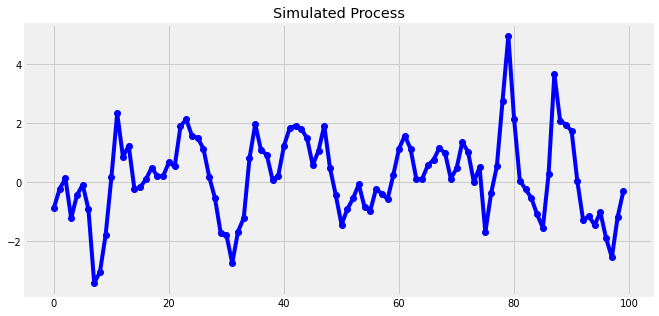

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
#from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Generate the data
import numpy as np
ar = np.array([1, -0.8, 0.2])
ma = np.array([1])
my_simulation = ArmaProcess(ar, ma).generate_sample(nsample=100)

plt.figure(figsize=[10, 5]); # Set dimensions for figure
plt.plot(my_simulation, linestyle='-', marker='o', color='b')
plt.title("Simulated Process")
plt.show()

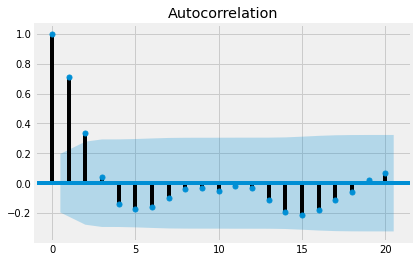

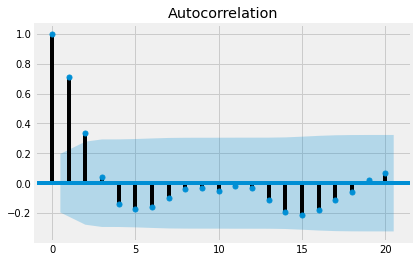

In [17]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
plot_acf(my_simulation)


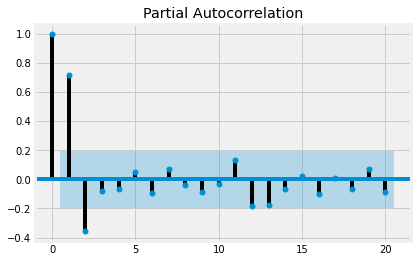

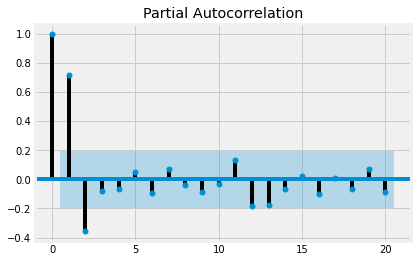

In [18]:
plot_pacf(my_simulation)

In [26]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 11.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=5526876a303d236458bdad1b958992d9fc07d463e2b0eeb1d223552971cda5e0
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [30]:
!pip install yahoofinancials

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-cp37-none-any.whl size=15192 sha256=ebfbcacace6bd38771aa924d792429750f017df2faf92273e2ac17109919d62b
  Stored in directory: /root/.cache/pip/wheels/d9/7e/cf/4977a8572d5247242a4b13018d1d36923024ba84236e0d28bc
Successfully built yahoofinancials


In [31]:
import pandas as pd
import yfinance as yf

from yahoofinancials import YahooFinancials
AMZN = yf.download('AMZN', start='2013-01-01', end='2019-12-31',progress=False)
# AMZN = yf.download('AMZN') for all 
all_data = AMZN[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data.head(10)

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2013-01-02,257.31,256.08,258.10,253.26,257.31,3271000
2013-01-03,258.48,257.27,260.88,256.37,258.48,2750900
2013-01-04,259.15,257.58,259.80,256.65,259.15,1874200
2013-01-07,268.46,262.97,269.73,262.67,268.46,4910000
2013-01-08,266.38,267.07,268.98,263.57,266.38,3010700
2013-01-09,266.35,268.17,269.50,265.40,266.35,2265600
2013-01-10,265.34,268.54,268.74,262.30,265.34,2863400
2013-01-11,267.94,265.10,268.43,264.11,267.94,2413300
2013-01-14,272.73,268.00,274.26,267.54,272.73,4275000


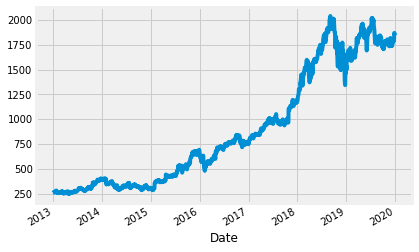

In [32]:
all_data['Adj Close'].plot()

In [33]:
print("There are "+ str(all_data[:'2018'].shape[0]) + " observations in the training data")
print("There are "+ str(all_data['2019':].shape[0]) + " observations in the test data")

There are 1510 observations in the training data
There are 251 observations in the test data


In [34]:
def ts_train_test(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test  = all_data['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test

X_train, y_train, X_test = ts_train_test(all_data,5,2)
X_train.shape[0],X_train.shape[1]

(1504, 5)

In [35]:

# Make the 3-D shape to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

,0,1,2,3,4,0,1
0,257.31,258.48,259.15,268.46,266.38,266.35,265.34
1,258.48,259.15,268.46,266.38,266.35,265.34,267.94
2,259.15,268.46,266.38,266.35,265.34,267.94,272.73
3,268.46,266.38,266.35,265.34,267.94,272.73,271.90
4,266.38,266.35,265.34,267.94,272.73,271.90,268.93
...,...,...,...,...,...,...,...
1499,1591.91,1520.91,1551.48,1495.08,1460.83,1377.45,1343.96
1500,1520.91,1551.48,1495.08,1460.83,1377.45,1343.96,1470.90
1501,1551.48,1495.08,1460.83,1377.45,1343.96,1470.90,1461.64
1502,1495.08,1460.83,1377.45,1343.96,1470.90,1461.64,1478.02


In [36]:
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_see)

,0,1,2,3,4
0,1343.96,1470.90,1461.64,1478.02,1501.97
1,1470.90,1461.64,1478.02,1501.97,1539.13
2,1461.64,1478.02,1501.97,1539.13,1500.28
3,1478.02,1501.97,1539.13,1500.28,1575.39
4,1501.97,1539.13,1500.28,1575.39,1629.51
...,...,...,...,...,...
244,1760.33,1760.94,1769.21,1790.66,1784.03
245,1760.94,1769.21,1790.66,1784.03,1792.28
246,1769.21,1790.66,1784.03,1792.28,1786.50
247,1790.66,1784.03,1792.28,1786.50,1793.00


In [37]:
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1504 samples in the training data
There are 249 samples in the test data


In [38]:
def simple_rnn_model(X_train, y_train, X_test):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)

    return my_rnn_model, rnn_predictions

my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test)
rnn_predictions[1:10]

array([[42.11214 , 38.496113],
       [42.11214 , 38.496113],
       [42.11214 , 38.496113],
       [42.11214 , 38.496113],
       [42.11214 , 38.496113],
       [42.11214 , 38.496113],
       [42.11214 , 38.496113],
       [42.11214 , 38.496113],
       [42.11214 , 38.496113]], dtype=float32)

(3059807.8, <matplotlib.axes._subplots.AxesSubplot at 0x7fdd7bc3fc10>)

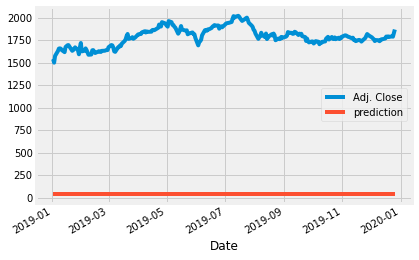

In [39]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )
    
actual_pred_plot(rnn_predictions)

(2943.5588, <matplotlib.axes._subplots.AxesSubplot at 0x7fdd7a743cd0>)

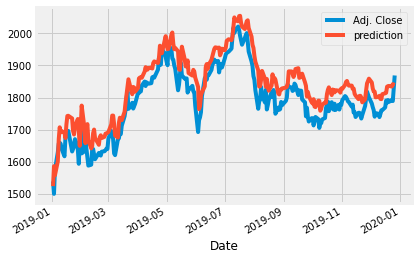

In [40]:
def ts_train_test_normalize(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test  = all_data['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)
    from sklearn.preprocessing import MinMaxScaler
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions


X_train, y_train, X_test, sc = ts_train_test_normalize(all_data,5,2)
my_rnn_model, rnn_predictions_2 = simple_rnn_model(X_train, y_train, X_test, sc)
rnn_predictions_2[1:10]
actual_pred_plot(rnn_predictions_2)

(1318.2103, <matplotlib.axes._subplots.AxesSubplot at 0x7fdd78bf8450>)

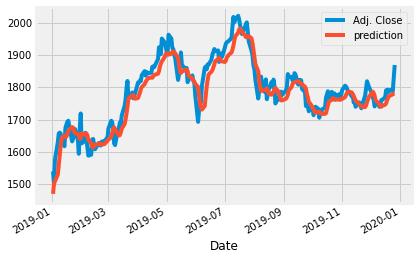

In [41]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from keras.optimizers import SGD
    
    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dense(units=2))

    # Compiling the RNN
    my_GRU_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return my_GRU_model, GRU_prediction

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

(1318.2103, <matplotlib.axes._subplots.AxesSubplot at 0x7fdd77d89390>)

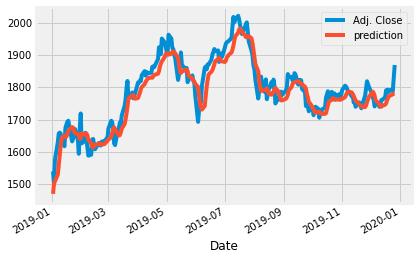

In [42]:
def GRU_model_regularization(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from keras.optimizers import SGD
    from keras.layers import Dropout
    
    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Second GRU layer
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    
    # Third GRU layer
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Fourth GRU layer
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # The output layer
    my_GRU_model.add(Dense(units=1))
    # Compiling the RNN
    my_GRU_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    GRU_predictions = my_GRU_model.predict(X_test)
    GRU_predictions = sc.inverse_transform(GRU_predictions)

    return my_GRU_model, GRU_predictions

my_GRU_model, GRU_predictions = GRU_model_regularization(X_train, y_train, X_test, sc)
GRU_predictions[1:10]
actual_pred_plot(GRU_prediction)